In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
#from keras.utils import np_utils
##from keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout, TimeDistributed
#from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
import io
import math
warnings.filterwarnings("ignore")

In [16]:
import torch
def read_train_patients():
    bg = []
    for patients_id in range(20):
         bg+=[pd.read_csv("Virtual_patients_20/V_CGMS_{}.csv".format( patients_id+1),header=None).values.ravel()]
    print(bg)
    return bg
bg = read_train_patients()
bg = np.array(bg)
bg = torch.from_numpy(bg)
bg[0][:10]


[array([118, 117, 116, 113, 110, 108, 108, 111, 113, 116, 118, 120, 122,
       125, 127, 128, 129, 129, 128, 126, 124, 122, 120, 120, 121, 125,
       127, 128, 126, 127, 130, 135, 138, 136, 130, 125, 122, 120, 118,
       115, 111, 109, 108, 108, 109, 110, 111, 112, 113, 115, 116, 116,
       115, 114, 115, 116, 117, 116, 114, 112, 112, 113, 114, 114, 113,
       113, 114, 116, 117, 116, 115, 114, 116, 119, 121, 122, 120, 119,
       118, 117, 116, 116, 115, 114, 113, 111, 110, 109, 110, 111, 113,
       115, 116, 117, 116, 116, 116, 117, 118, 120, 121, 122, 121, 119,
       117, 115, 114, 113, 114, 116, 122, 130, 142, 154, 167, 179, 189,
       197, 202, 207, 211, 216, 220, 223, 226, 227, 226, 224, 221, 219,
       217, 215, 213, 211, 209, 206, 202, 199, 195, 192, 188, 183, 179,
       175, 173, 172, 173, 177, 185, 199, 218, 239, 261, 281, 300, 312,
       318, 316, 314, 312, 311, 308, 303, 295, 288, 283, 280, 278, 276,
       275, 271, 266, 258, 250, 244, 239, 235, 231, 227, 225, 2

tensor([118, 117, 116, 113, 110, 108, 108, 111, 113, 116])

In [17]:
def split_to_xy(data, input_size=8, output_term=6):
    x = []
    y = []

    for data_per_patient in data:
        for i in range(input_size, len(data_per_patient)-output_term):
            x.append(data_per_patient[i-input_size:i])
            y.append(data_per_patient[i+output_term-1])

    return x, y

In [22]:
x, y = split_to_xy(bg)

print(len(x), len(y))

17000 17000


In [6]:
train_patients_num =14
test_patients_num = 6

def moving_average(a, n=3): 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret/=n
    # Masking
    ret[:n-1]=ret[n-1]
    return ret


def read_train_patients(input_len = 8, output_len = 6):
    x_train=[]
    y_train_f = []
    y_train=[]
    for i in range(1, 15):
        y_noised=[]
        
        df=pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
        dataset=df.values
        
        # Scalling data from 0 - 1 to input in the neural network
        scaler = MinMaxScaler(feature_range=(0, 1)) 
        # scaled_data = scaler.fit_transform(dataset)
        # train_data = scaled_data
        train_data = dataset
        
        for i in range(input_len,len(train_data)-output_len):
            x_train.append(train_data[i-input_len:i,0])
            y_train.append(train_data[i+output_len-1,0])
            #y_noised.append(train_data[i+output_len-1,0])
        
        # y_noised = moving_average(y_noised)
        # y_train_f.extend(y_noised)
        
        #for i in range(input_len,len(train_data)-output_len):
        #    x_train.append(train_data[i-input_len:i,0])
        #    y_train.append(train_data[i+output_len-1,0])
        
        
            
    x_train, y_train, y_train_f = np.array(x_train), np.array(y_train), np.array(y_train_f)
    print("x_train:", np.shape(x_train))
    #print("y_train:", np.shape(y_train))
    print("y_train_f:", np.shape(y_train_f))
    #reshape 
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    #show_plots(0, y_train[:800], y_train_f[:800])
    
    return scaler, x_train, y_train
    #return scaler, x_train, y_train_f

In [14]:
def train_model(scaler, x_train, y_train, batch_size=1, epochs=1):
    X_val = x_train[9000:]
    Y_val = y_train[9000:]
    X_train = x_train[:9000]
    Y_train = y_train[:9000]

    # 라벨링 전환
    Y_train = np_utils.to_categorical(Y_train)
    Y_val = np_utils.to_categorical(Y_val)
    
    # LSTM Model
    model = Sequential()
    model.add(LSTM(units=20, return_sequences=False,input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.5))
    model.add(Dense(8))
    model.add(Dense(1))
    print(model.summary())

    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    
    #X_val = x_train[9000:]
    #Y_val = y_train[9000:]
    #X_train = x_train[:9000]
    #Y_train = y_train[:9000]
    
    #print(len(X_val))
    #print(len(Y_val))
    #print(len(X_train))
    #print(len(Y_train))
    
    # Y_train = np_utils.to_categorical(Y_train)
    # Y_val = np_utils.to_categorical(Y_val)

    #over fitting 방지
    early_stopping = EarlyStopping(monitor='loss', patience=50, mode='auto')

    hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping],validation_data=(X_val, Y_val))
    #hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])
    
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()
    
    return model
    
    """predictions = model.predict(x_test) # make predictions
    predictions = np.reshape(predictions, (predictions.shape[0],predictions.shape[1])) # reshape just like y_test

    predictions = scaler.inverse_transform(predictions) # reverse data

    # Create a continuous data of predictions to plot with continuous_ytest
    continuous_predictions = predictions[0]
    for i in range(1,len(predictions)):
        continuous_predictions = np.concatenate([continuous_predictions,predictions[i]])

    rmse=np.sqrt(np.mean(((predictions-y_test)**2)))
    mape=np.mean(np.abs((prediction-y)/y_test)*100)
    return model, predictions, continuous_predictions, rmse,mape"""
    

In [15]:
def show_plots(i, continuous_ytest, continuous_predictions):
    plt.figure(figsize=(16,8))
    plt.title('Blood Glucose Prediction Model Result_patient_{}'.format(i))
    plt.plot(continuous_ytest, color = 'b')
    plt.plot(continuous_predictions, color = 'r')
    plt.xlabel('Timestamp',fontsize=10)
    plt.ylabel('BG(CGM) (mg/dL)',fontsize=10)
    plt.legend(['Real','Predictions'], loc='lower right')
    plt.show()

x_train: (11900, 8)
y_train_f: (0,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,937
Trainable params: 1,937
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1800/1800 [==============================] - 6s 2ms/step - loss: 0.0582 - accuracy: 0.9868 - val_loss: 0.0046 - val_accuracy: 0.9954
Epoch 2/500
1800/1800 [==============================] - 4s 2ms/

Epoch 51/500
1800/1800 [==============================] - 3s 2ms/step - loss: 0.0024 - accuracy: 0.9976 - val_loss: 0.0046 - val_accuracy: 0.9954
Epoch 52/500
1800/1800 [==============================] - 3s 2ms/step - loss: 0.0024 - accuracy: 0.9976 - val_loss: 0.0046 - val_accuracy: 0.9954
Epoch 53/500
1800/1800 [==============================] - 4s 2ms/step - loss: 0.0024 - accuracy: 0.9976 - val_loss: 0.0046 - val_accuracy: 0.9954
Epoch 54/500
1800/1800 [==============================] - 3s 2ms/step - loss: 0.0024 - accuracy: 0.9976 - val_loss: 0.0046 - val_accuracy: 0.9954
Epoch 55/500
1800/1800 [==============================] - 4s 2ms/step - loss: 0.0024 - accuracy: 0.9976 - val_loss: 0.0046 - val_accuracy: 0.9954
Epoch 56/500
1800/1800 [==============================] - 3s 2ms/step - loss: 0.0024 - accuracy: 0.9976 - val_loss: 0.0046 - val_accuracy: 0.9954
Epoch 57/500
1800/1800 [==============================] - 3s 2ms/step - loss: 0.0024 - accuracy: 0.9976 - val_loss: 0.0046 -

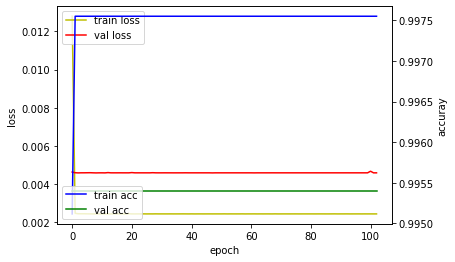

In [16]:
scaler, x_train, y_train = read_train_patients()
#x_train, y_train = read_train_patients()
model = train_model(scaler, x_train, y_train, batch_size= 5, epochs=500)  
#model = train_model(x_train, y_train, batch_size =20, epochs=500)  

In [12]:
#LSTM
def test_model(model, i, input_len=8, output_len=6):
    df = pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
    dataset=df.values
    
    # Scalling data from 0 - 1 to input in the neural network
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_data = scaler.fit_transform(dataset)
    
    x_test =[]
    y_test =[]
    
    continuous_ytest=[]
    i= input_len
    
    for i in range(input_len,len(dataset)-output_len):
        #x_test.append(scaled_data[i-input_len:i,0])
        x_test.append(dataset[i-input_len:i,0])
        y_test.append(dataset[i+output_len-1,0])
        continuous_ytest.append(dataset[i+output_len-1,0])
        i = i+output_len

    x_test = np.array(x_test)
    print("x_test: ", x_test)
    x_test= np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #y_test = moving_average(y_test)
    continuous_ytest=np.array(continuous_ytest)
    
    #continuous_ytest=moving_average(continuous_ytest)
    
    predictions = model.predict(x_test)
    print("predictions: ", predictions)
    predictions = np.reshape(predictions,(predictions.shape[0],predictions.shape[1]))
    #pred =[]
    #for i in range(len(predictions)):
    #    pred.append(np.mean(predictions[i]))
    #pred = np.array(pred)
    #pred = np.reshape(pred,(len(pred),1))
    #predictions = scaler.inverse_transform(predictions)
    #prn
    continuous_predictions = predictions[0]
    for i in range(1, len(predictions)):
        continuous_predictions = np.concatenate([continuous_predictions, predictions[i]])
    
    rmse=np.sqrt(np.mean(((predictions-y_test)**2)))
    mape=np.mean(np.abs((predictions-y_test)/y_test)*100)
    #print("prediction:", np.shape(pred))
    #print("y_test:",np.shape(y_test))
    #print(len(continuous_ytest))
    print("continuous_predictions: ", continuous_predictions)
    return rmse, mape, continuous_ytest, continuous_predictions

x_test:  [[110 108 105 ...  99  98  98]
 [108 105 103 ...  98  98  98]
 [105 103 101 ...  98  98 100]
 ...
 [153 148 143 ... 130 129 128]
 [148 143 137 ... 129 128 125]
 [143 137 132 ... 128 125 121]]
predictions:  [[0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 

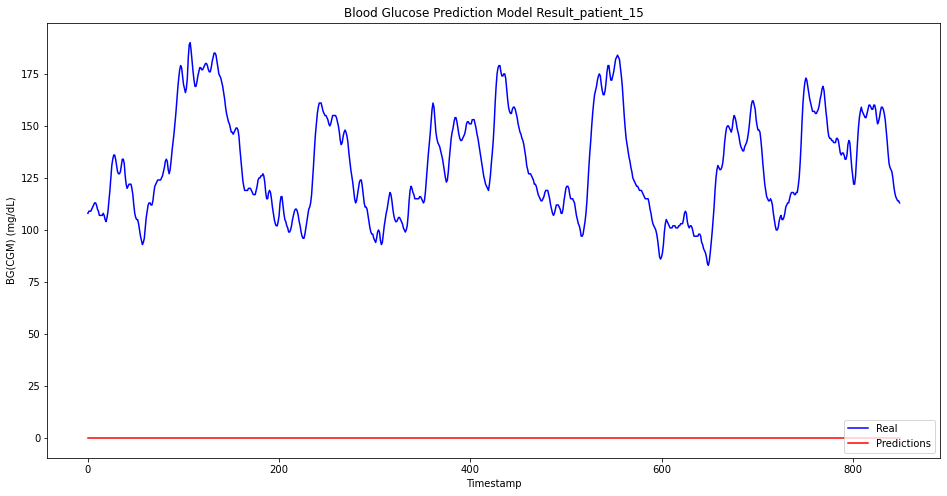

Root-Mean-Squared Deviation 133.7997963182272
Mean-Absolute-Percentage-Error 99.99807512626892
x_test:  [[125 126 127 ... 133 134 134]
 [126 127 129 ... 134 134 133]
 [127 129 131 ... 134 133 131]
 ...
 [114 112 109 ... 104 104 103]
 [112 109 107 ... 104 103 103]
 [109 107 105 ... 103 103 103]]
predictions:  [[0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.

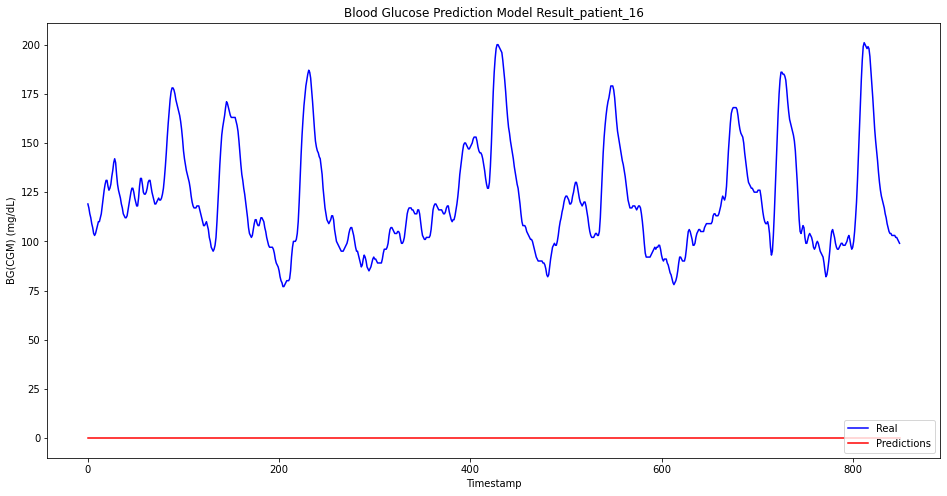

Root-Mean-Squared Deviation 124.22090261152164
Mean-Absolute-Percentage-Error 99.99788707820561
x_test:  [[119 117 116 ... 111 111 111]
 [117 116 114 ... 111 111 111]
 [116 114 112 ... 111 111 112]
 ...
 [172 169 166 ... 154 148 142]
 [169 166 163 ... 148 142 137]
 [166 163 159 ... 142 137 132]]
predictions:  [[0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0

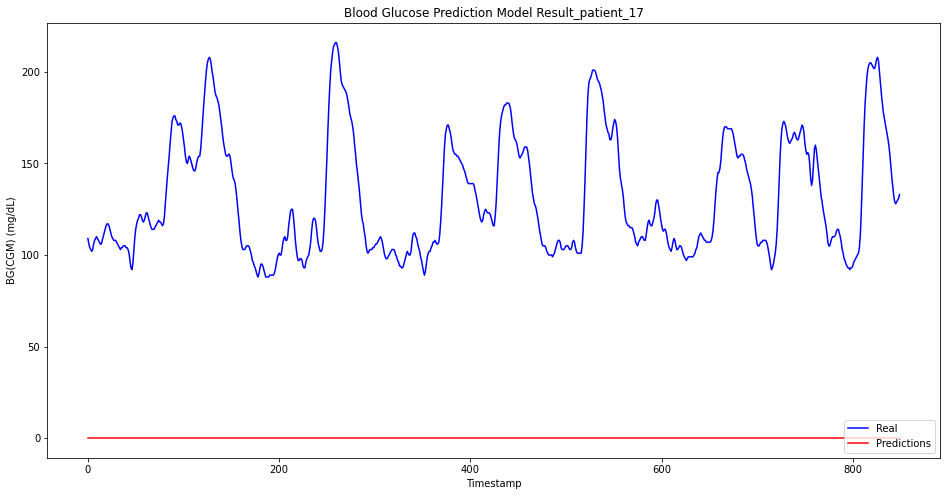

Root-Mean-Squared Deviation 135.29577713143408
Mean-Absolute-Percentage-Error 99.99803418809458
x_test:  [[140 145 149 ... 146 144 142]
 [145 149 150 ... 144 142 141]
 [149 150 148 ... 142 141 141]
 ...
 [186 185 184 ... 183 184 184]
 [185 184 183 ... 184 184 184]
 [184 183 182 ... 184 184 183]]
predictions:  [[0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0

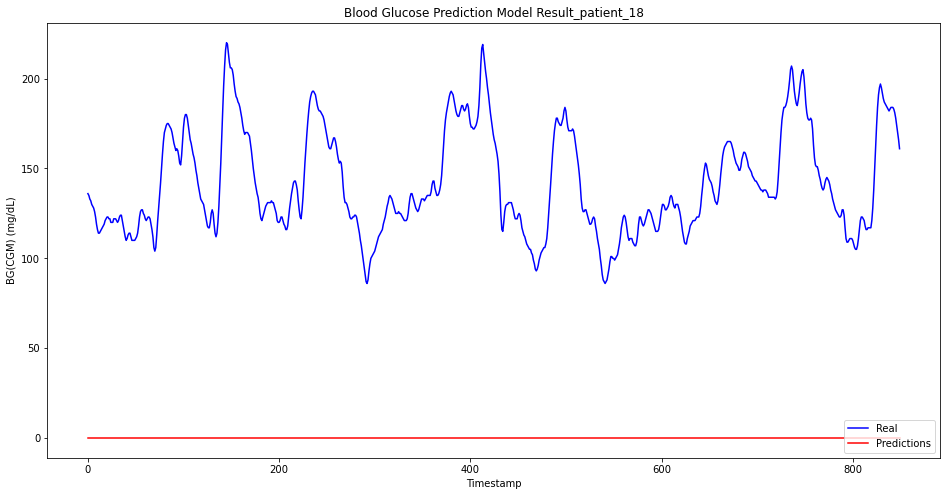

Root-Mean-Squared Deviation 144.3365647787973
Mean-Absolute-Percentage-Error 99.99820232523368
x_test:  [[103 103 104 ... 113 113 112]
 [103 104 106 ... 113 112 110]
 [104 106 110 ... 112 110 109]
 ...
 [164 160 158 ... 155 153 151]
 [160 158 157 ... 153 151 148]
 [158 157 156 ... 151 148 144]]
predictions:  [[0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.

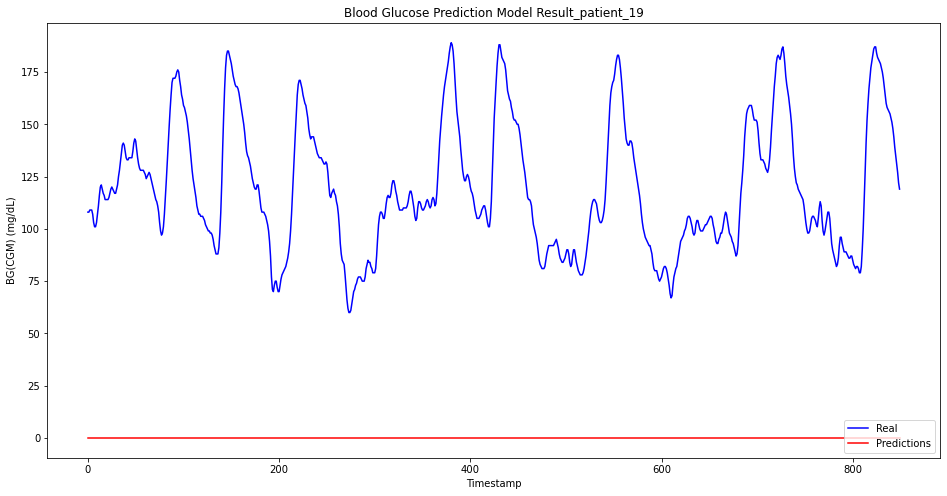

Root-Mean-Squared Deviation 123.42133268711997
Mean-Absolute-Percentage-Error 99.99781568408643
x_test:  [[131 131 130 ... 125 124 123]
 [131 130 129 ... 124 123 123]
 [130 129 127 ... 123 123 122]
 ...
 [112 114 114 ... 113 114 115]
 [114 114 113 ... 114 115 116]
 [114 113 112 ... 115 116 118]]
predictions:  [[0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0.00244401]
 [0

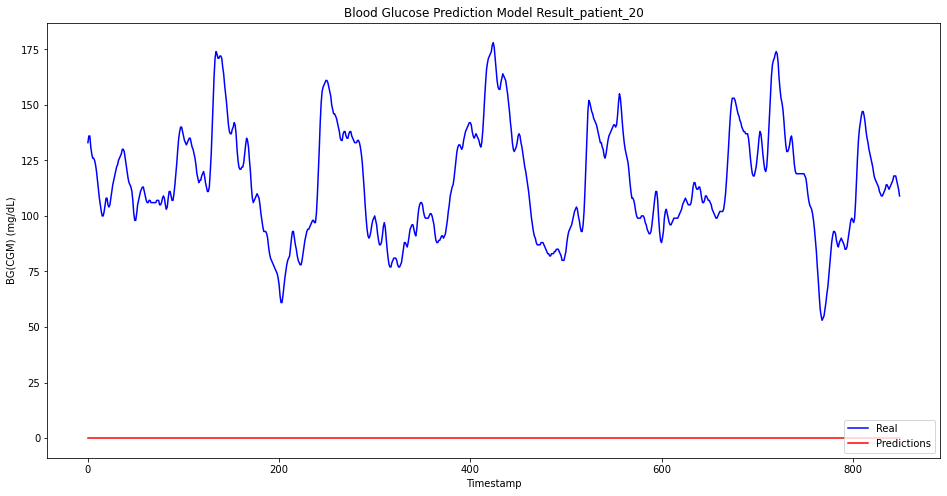

Root-Mean-Squared Deviation 117.45640398692005
Mean-Absolute-Percentage-Error 99.99776789617289


In [13]:
for i in range(15,21):
    rmse, mape, continuous_ytest, continuous_predictions = test_model(model, i)
    show_plots(i, continuous_ytest, continuous_predictions)
    print("Root-Mean-Squared Deviation {}".format(rmse))
    print("Mean-Absolute-Percentage-Error {}".format(mape))